# Section 5: Regridding

## Set up

In [1]:
from esmf_regrid.experimental.unstructured_scheme import MeshToGridESMFRegridder, GridToMeshESMFRegridder
from iris.coords import DimCoord
from iris.cube import Cube

## Example: Regridding LFRic data

Suppose we need to compare data located on two different kinds of grids. One is located on a UM style "latlon" _grid_ and one is located on an LFRic style cubed sphere UGRID _mesh_. Data can be translated from the grid to the mesh and vice versa via _regridding_. We will demonstrate with the following files:

In [2]:
from testdata_fetching import lfric_orography, um_orography
mesh_cube = lfric_orography()
mesh_cube

Surface Altitude (m),--
Shape,221184
Mesh coordinates,
latitude,x
longitude,x
Mesh,
name,Topology data of 2D unstructured mesh
location,face
Scalar coordinates,
forecast_period,21600 seconds
forecast_reference_time,2021-03-24 00:00:00


In [3]:
grid_cube = um_orography()
grid_cube

<iris 'Cube' of surface_altitude / (m) (latitude: 480; longitude: 640)>

Regridding unstructured data is more complex than the regridders contained in Iris and requires making use of powerful libraries (`ESMF`). The `iris-esmf-regrid` package provides a bridge from iris to esmf with objects that interact directly with iris cubes. The `MeshToGridESMFRegridder` class allows the regridding of (LFRic style) mesh cubes onto (UM style) latlon grid cubes.

First we initialise the regridder object with a source mesh cube and target grid cube...

In [4]:
# Initialise the regridder.
# This object can be re-used and also saved/re-loaded.
# Note: it may take a few seconds to initialise the regridder.
regridder = MeshToGridESMFRegridder(mesh_cube, grid_cube)

...Then we use that regridder object to translate the data onto the grid of the target cube.

In [5]:
# Regrid the mesh cube.
regridded_orography = regridder(mesh_cube)
regridded_orography

<iris 'Cube' of surface_altitude / (m) (latitude: 480; longitude: 640)>

The reason this is done in two steps is because initialising a regridder is potentially quite expensive if the grids or meshes involved are large. Once initialised, a regridder can regrid many source cubes (defined on the same source grid/mesh) onto the same target. We can demonstrate this by regridding a different cube using the same regridder.

In [6]:
# Load an air temperature cube.
from testdata_fetching import lfric_temp
mesh_temp = lfric_temp()

# We can check that this cube shares the same mesh.
assert mesh_temp.mesh == mesh_cube.mesh

mesh_temp

Air Temperature (K),time,pressure,--
Shape,24,17,221184
Dimension coordinates,,,
time,x,-,-
pressure,-,x,-
Mesh coordinates,,,
latitude,-,-,x
longitude,-,-,x
Auxiliary coordinates,,,
forecast_period,x,-,-
Mesh,,,


In [7]:
# Regrid the new mesh cube using the same regridder.
# Note how the time coordinate is also transposed in the result.
regridded_temperature = regridder(mesh_temp)
regridded_temperature

<iris 'Cube' of air_temperature / (K) (time: 24; pressure: 17; latitude: 480; longitude: 640)>

We can save time in future runs by saving and loading a regridder with `save_regridder` and `load_regridder`.

*Note:* The information for the regridder is saved as a NetCDF file so the file name must have a `.nc` extension.

In [8]:
# This code is commented for the time being to avoid generating files.

# from esmf_regrid.experimental.io import load_regridder, save_regridder

# save_regridder(regridder, "lf_to_um_regridder.nc")
# loaded_regridder = load_regridder("lf_to_um_regridder.nc")

We can compare the regridded file to an equivalent file from the UM.

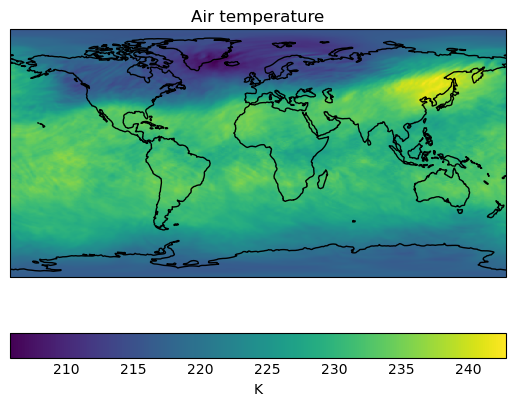

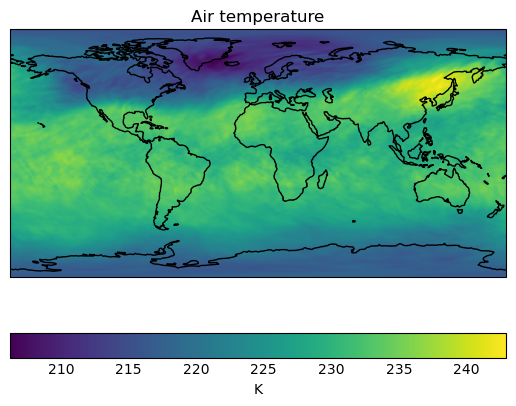

In [10]:
import iris.quickplot as iqplt
import matplotlib.pyplot as plt

from testdata_fetching import um_temp
grid_temp = um_temp()

# We slice the cube to make sure it is 2D for plotting.
iqplt.pcolormesh(grid_temp[0, 0])
plt.gca().coastlines()
plt.show()

iqplt.pcolormesh(regridded_temperature[0, 0])
plt.gca().coastlines()
plt.show()

We can then plot the difference between the UM data and the data regridded from LFRic. Since all our data is now on a latlon grid we can subtract to find the difference between the regridded LFRic data and equivalent UM data and plot this with matplotlib as normal.

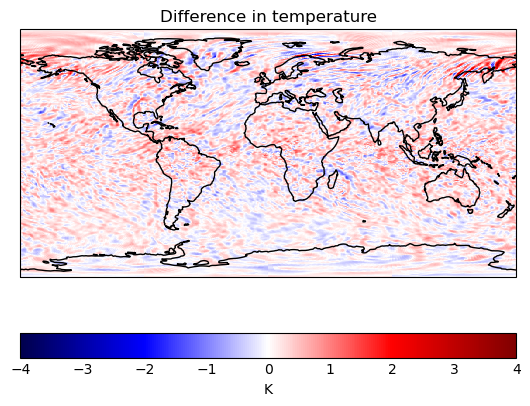

In [12]:
temp_diff = regridded_temperature - grid_temp
temp_diff.long_name = "Difference in temperature"

# We choose a colormap that makes it clear where the differences are.
iqplt.pcolormesh(temp_diff[0, 0], vmin=-4,vmax=4, cmap="seismic")
plt.gca().coastlines()
plt.show()

We can also regrid from latlon grids to LFRic style meshes using `GridToMeshESMFRegridder`.

In [13]:
# Initialise the regridder.
g2m_regridder = GridToMeshESMFRegridder(grid_cube, mesh_cube)
# Regrid the grid cube.
orography_on_mesh = g2m_regridder(grid_cube)
orography_on_mesh

Surface Altitude (m),--
Shape,221184
Mesh coordinates,
latitude,x
longitude,x
Mesh,
name,Topology data of 2D unstructured mesh
location,face
Scalar coordinates,
forecast_period,21600 seconds
forecast_reference_time,2021-03-24 00:00:00


In [14]:
# Bonus task:
# Use %%timeit to investigate how much time it takes to initialise a regridder vs applying the regridder.

## Exercise 1: Comparing regridding methods

By default, regridding uses the area weighted `conservative` method. We can also use the bilinear regridding method.

**Step 1:** Use the `method="bilinear"` keyword to initialise a bilinear `MeshToGridESMFRegridder` with arguments `mesh_cube` and `grid_cube`.

In [15]:
bilinear_regridder = MeshToGridESMFRegridder(mesh_cube, grid_cube, method="bilinear")

**Step 2:** Use this regridder to regrid `mesh_cube`.

In [16]:
bilinear_regridded_orography = bilinear_regridder(mesh_cube)

**Step 3:** Compare this result with the result from the default area weighted conservative regridder.

In [17]:
bilinear_diff = bilinear_regridded_orography - regridded_orography

**Step 4:** Plot the results and the difference using `iris.quickplot` and `matplotlib`.

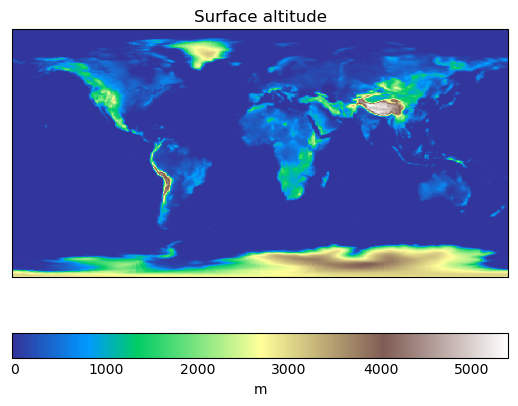

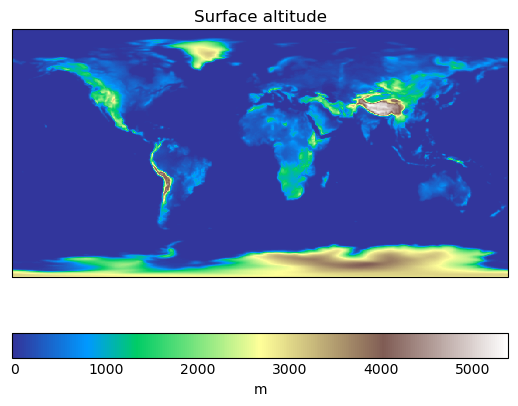

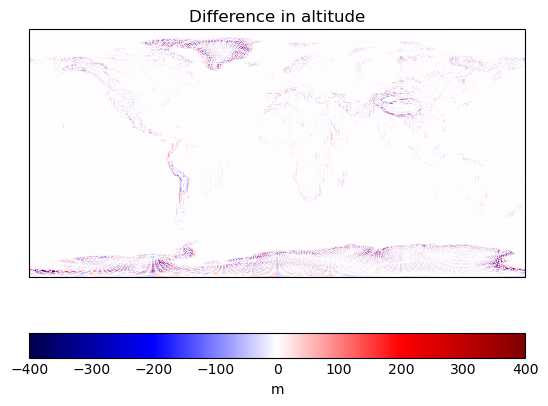

In [18]:
import iris.quickplot as iqplt
import matplotlib.pyplot as plt

iqplt.pcolormesh(regridded_orography, cmap="terrain")
plt.show()
iqplt.pcolormesh(bilinear_regridded_orography, cmap="terrain")
plt.show()
bilinear_diff.long_name = "Difference in altitude"
iqplt.pcolormesh(bilinear_diff, vmin=-400,vmax=400, cmap="seismic")
plt.show()

In [19]:
# Bonus Exercises:
# - calculate the difference between methods for the GridToMeshESMFRegridder.
# - calculate the difference between raw data and data which has been round tripped.
# (e.g. regrid from mesh to grid then from grid to mesh)
# - demonstrate that the data in the grid file was probably a result of regridding from the mesh file.

## Exercise 2: Zonal means

For a latlon cube, a common operation is to collapse over longitude by taking an average. This is not possible for an LFRic style mesh cube since there is no independent longitude dimension to collapse. While it is possible to regrid to a latlon cube and then collapse, this introduces an additional step to the process. Instead, it is possible to simplify this into a single step by considering this as a regridding operation where the target cube contains multiple latitude bands.

A zonal mean is the area weighted average over a defined region or sequence of regions. e.g. a band of latitude/longitude.
Calculating zonal means can be done as a regridding operation where the zone is defined by the target cube. This can involve a target cube with a single cell or, as in this example, a number of cells along the latitude dimension.

**Step 1:** Define a latitude coordinate whose bounds are `[[-90, -60], [-60, -30], [-30, 0], [0, 30], [30, 60], [60, 90]]`. Remember to set the standard name to be `"latitude"` and the units to be `"degrees"`

In [20]:
lat_bands = DimCoord(
    [-75, -45, -15, 15, 45, 75],
    bounds=[[-90, -60], [-60, -30], [-30, 0], [0, 30], [30, 60], [60, 90]],
    standard_name="latitude",
    units="degrees"
)

**Step 2:** Define a longitude coordinate whose bounds are `[[-180, 180]]`. Remember to set the standard name to be `"longitude"` and the units to be `"degrees"`

In [21]:
lon_full = DimCoord(0, bounds=[[-180, 180]], standard_name="longitude", units="degrees")

**Step 3:** Create a six celled cube (i.e. `Cube([[0, 0, 0, 0, 0, 0]])`) and attach the latitude and longitude coordinates to it.

In [22]:
lat_band_cube = Cube([[0, 0, 0, 0, 0, 0]])
lat_band_cube.add_dim_coord(lat_bands, 1)
lat_band_cube.add_dim_coord(lon_full, 0)
lat_band_cube

Unknown (unknown),longitude,latitude
Shape,1,6
Dimension coordinates,,
longitude,x,-
latitude,-,x


**Step 4:** Create a regridder from `mesh_cube` to the single celled cube you created.

*Note:* ESMF represents all lines as sections of great circles rather than lines of constant latitude. This means that `MeshToGridESMFRegridder` would  fail to properly handle such a large cell. We can solve this problem by using the `resolution` keyword. By providing a `resolution`, we divide each cell into as many sub-cells each bounded by the same latitude bounds.

If we initialise a regridder with `MeshToGridESMFRegridder(src_mesh, tgt_grid, resolution=10)`, then the lines of latitude bounding each of the cells in `tgt_grid` will be *approximated* by 10 great circle sections.

Initialise a `MeshToGridESMFRegridder` with `mesh_cube` and your single celled cube as its arguments and with a `resolution=10` keyword.

In [23]:
lat_band_mean_calculator_10 = MeshToGridESMFRegridder(mesh_cube, lat_band_cube, resolution=10)

**Step 5:** Apply this regridder to `mesh_cube` and print the data from this result (i.e. `print(result_cube.data)`) and plot with `iqplt.pcolormesh`.

[[834.3404501938949]
 [22.911713801134844]
 [144.84938200705713]
 [173.82307542995312]
 [419.66049216165635]
 [267.17610202883344]]


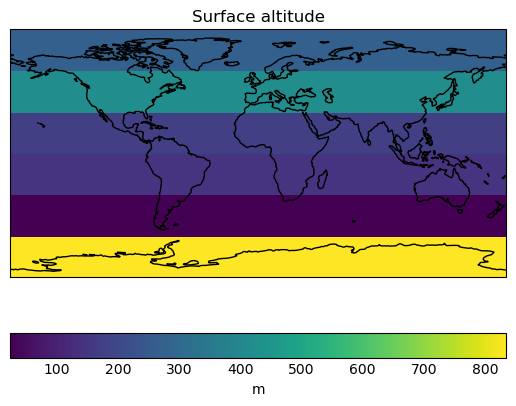

In [24]:
lat_band_mean_10 = lat_band_mean_calculator_10(mesh_cube)
print(lat_band_mean_10.data)
iqplt.pcolormesh(lat_band_mean_10)
plt.gca().coastlines()
plt.show()

**Step 6:** Repeat step 4 and 5 for `resolution=100`.

Note the difference in value. Also note that it takes more time to initialise a regridder with higher resolution. Higher resolutions ought to be more accurate but there is a tradeoff between performance and accuracy.

[[790.6355533520023]
 [25.988278381067268]
 [145.97213673743698]
 [163.82279492506785]
 [428.4158694964161]
 [265.59292488249076]]


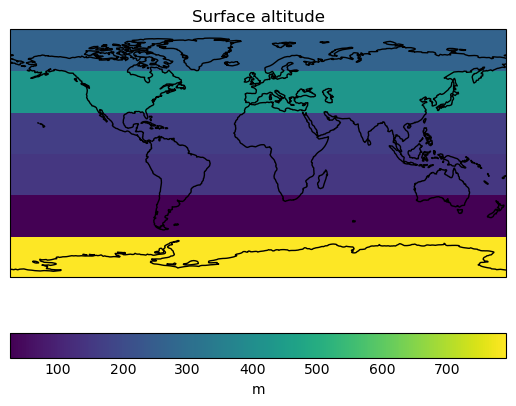

In [25]:
lat_band_mean_calculator_100 = MeshToGridESMFRegridder(mesh_cube, lat_band_cube, resolution=100)
lat_band_mean_100 = lat_band_mean_calculator_100(mesh_cube)
print(lat_band_mean_100.data)

iqplt.pcolormesh(lat_band_mean_100)
plt.gca().coastlines()
plt.show()

**Step 7:** Repeat steps 1 - 6 for latitude bounds `[[-90, 90]]`, longitude bounds `[[-40, 40]]` and resolutions 2 and 10.

*Note:* Unlike lines of constant latitude, lines of constant longitude are already great circle arcs.This might suggest that the `resolution` argument is unnnecessary, however these arcs are 180 degrees which ESMF is unable to represent so we still need a `resolution` of at least 2. In this case, an increase in resolution will not affect the accuracy since a resolution of 2 will already have maximum accuracy. Note how the results are the equal.

In [26]:
lat_full = DimCoord(0, bounds=[[-90, 90]], standard_name="latitude", units="degrees")
lon_band = DimCoord(0, bounds=[[-40, 40]], standard_name="longitude", units="degrees")

lon_band_cube = Cube([[0]])
lon_band_cube.add_dim_coord(lat_full, 0)
lon_band_cube.add_dim_coord(lon_band, 1)

lon_band_mean_calculator_2 = MeshToGridESMFRegridder(mesh_cube, lon_band_cube, resolution=2)
lon_band_mean_2 = lon_band_mean_calculator_2(mesh_cube)
print(lon_band_mean_2.data)

lon_band_mean_calculator_10 = MeshToGridESMFRegridder(mesh_cube, lon_band_cube, resolution=10)
lon_band_mean_10 = lon_band_mean_calculator_10(mesh_cube)
print(lon_band_mean_10.data)

[[257.1388582231515]]
[[257.1388582231515]]


## Exercise 3: Hovmoller plots

If we have data on aditional dimensions, we can use the same approach as exercise 2 to produce a Hovmoller diagram. That is, if we have data that varies along time we can take the area weighted mean over latitude bands and plot the data aginst latitude and time (or similarly, we can plot against longitude and time).

**Step 1:** Load a cube with humidity data using the `testdata_fetching` function `lfric_rh_alltimes_3d`.

In [27]:
from testdata_fetching import lfric_rh_alltimes_3d

humidity_cube = lfric_rh_alltimes_3d()
humidity_cube

<iris 'Cube' of relative_humidity_at_screen_level / (1) (time: 24; -- : 221184)>

**Step 2:** Create a target cube whose latitude coordinate is derived from the UM cube loaded from `um_orography` and whose longitude coordinate has bounds `[[-180, 180]]`. This can be done by slicing a cube derived from `um_orography` (using the slice `[:, :1]` so that this dimension isnt collapsed), removing the longitude coordinate and adding a longitude coordinate with bounds `[[-180, 180]]` (you can reuse the coordinate from exercise 2).

In [28]:
target_cube_lats = grid_cube[:,:1]
target_cube_lats.remove_coord("longitude")
target_cube_lats.add_dim_coord(lon_full, 1)
target_cube_lats

<iris 'Cube' of surface_altitude / (m) (latitude: 480; longitude: 1)>

In [29]:
# We also can do the same thing for bands of constant longitude.

# target_cube_lons = grid_cube[:1]
# target_cube_lons.remove_coord("latitude")
# target_cube_lons.add_dim_coord(lat_full, 0)
# target_cube_lons

**Step 3:** Create a `MeshToGridESMFRegridder` regridder from the slice of the humidity cube onto the target cube. Set the resolution keyword to 500 (this should be good balance of accuracy and performance). Use this regridder to create a resulting cube.

In [30]:
um_lat_band_mean_calculator = MeshToGridESMFRegridder(humidity_cube, target_cube_lats, resolution=500)
um_lat_band_means = um_lat_band_mean_calculator(humidity_cube)
um_lat_band_means

<iris 'Cube' of relative_humidity_at_screen_level / (1) (time: 24; latitude: 480; longitude: 1)>

In [31]:
# Continuing for bands of constant longitude.
# Note: this code takes about 2 minutes to run. I think this is due to with the way ESMF handles cells
# with unusual shapes. See https://github.com/SciTools-incubator/iris-esmf-regrid/issues/234.

# um_lon_band_mean_calculator = MeshToGridESMFRegridder(humidity_cube, target_cube_lons, resolution=2)
# um_lon_band_means = um_lon_band_mean_calculator(humidity_cube)
# um_lon_band_means

**Step 4:** Plot the data in the resulting cube. This can be done with `iqplt.pcolormesh`. Note that the resulting cube will have an unnecessary dimension which will have to be sliced (using `[:, :, 0]`). Note that extra steps can be taken to format the dates for this plot.

/home/h01/sworsley/.conda/envs/mint38/lib/python3.8/site-packages/iris/coords.py:2047: UserWarning: Coordinate 'time' is not bounded, guessing contiguous bounds.
  warnings.warn(


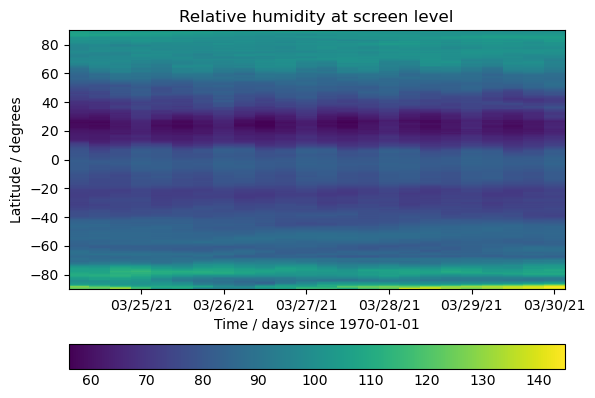

In [32]:
import matplotlib.dates as mdates
# We use a colormap which highlights fine details.
iqplt.pcolormesh(um_lat_band_means[:, :, 0])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%D"))
plt.show()

In [33]:
# Continuing for bands of constant longitude.

# iqplt.pcolormesh(um_lon_band_means[:, 0])
# plt.gca().yaxis.set_major_formatter(mdates.DateFormatter("%D"))
# plt.show()

In [34]:
# Bonus Exercise:

# Create a regridder onto a single celled cube which represents the whole earth.
# Use this regridder to compare how well bilinear regridding and area weighted
# regridding preserve area weighted mean after round tripping.